In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")

In [3]:
Tr.fit(modelpath="tmp_Qnet.joblib")

In [4]:
pd.DataFrame(samples)

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,4,2,5,4,2,3,2,3,3,2,...,2,4,4,3,2,3,2,2,4,2
1,3,2,3,3,1,3,2,2,2,1,...,3,4,4,3,3,3,4,3,4,5
2,2,2,2,4,1,3,3,2,2,4,...,4,2,2,4,4,2,3,2,2,5
3,2,2,5,1,3,2,1,2,2,1,...,1,2,3,3,3,2,1,1,2,2
4,4,1,1,1,2,2,1,1,1,2,...,2,2,2,2,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,4,2,3,4,1,1,1,1,3,2,...,2,2,2,2,2,2,2,2,2,3
300,5,2,2,4,4,3,2,5,4,4,...,5,5,5,5,4,5,5,4,4,5
301,5,1,2,1,1,3,5,5,3,4,...,4,3,3,2,3,1,3,2,5,5
302,2,1,3,3,1,2,2,2,1,1,...,1,1,1,1,1,2,2,2,2,2


In [5]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _compare_dissonance(samples, qnet, diss_fcn=_diss_linear, plot=True):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    mean_diss_random = list()
    mean_diss_qsampled = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")

    Ds = qnet.predict_distributions(new_samp_r)
    entrpy = list()
    for i in range(len(Ds)):
        entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

    for i in pd.Series(entrpy).sort_values().index:
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_random = np.array(mean_diss_random)
    mean_df = pd.DataFrame({"random": mean_diss_random, "qsampled": mean_diss_qsampled})

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return mean_df

## Linear dissonance

In [10]:
mean_dfs = [
    _compare_dissonance(samples, Tr.cognet_obj.qnet, plot=False)
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

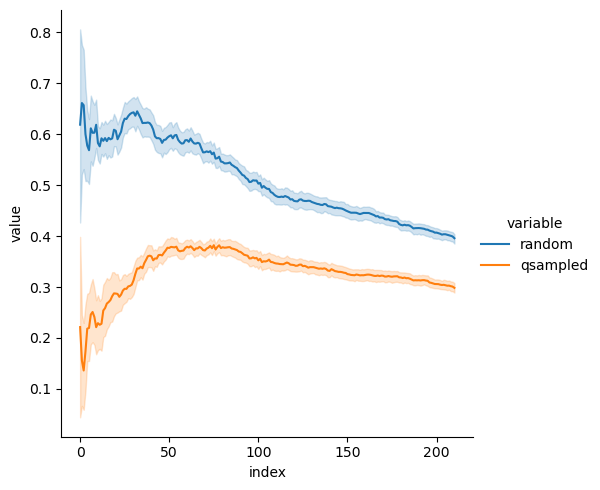

In [16]:
sns.relplot(
    data=pd.melt(pd.concat(mean_dfs).reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Log. dissonance

In [6]:
mean_dfs = [
    _compare_dissonance(samples, Tr.cognet_obj.qnet, diss_fcn=_diss_log, plot=False)
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

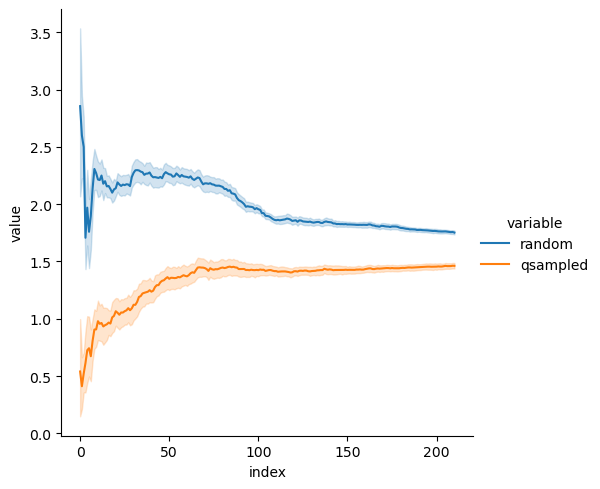

In [7]:
sns.relplot(
    data=pd.melt(pd.concat(mean_dfs).reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)